# Synthetic Ice IR Spectra generator based on SPECFY(LIDA)

In [18]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d # Scipy module for interpolation

### Interpolation module

In [19]:
# Function to interpolate absorbance values at wavelength values other than datapoints
def interpolation(wavelength,absorbance,min_wavelength, max_wavelength,r):
    # Perform linear interpolation
    interpolated_wavelength = np.linspace(max(math.ceil(wavelength[0]),min_wavelength), min(math.floor(wavelength[-1]),max_wavelength), num=int((min(math.floor(wavelength[-1]),max_wavelength)-max(math.ceil(wavelength[0]),min_wavelength))/r + 1))  # New wavelength range
    interpolator = interp1d(wavelength, absorbance, kind='cubic')  # Cubic interpolation
    interpolated_absorbance = interpolator(interpolated_wavelength)  # Interpolated absorbance values
    return interpolated_wavelength,interpolated_absorbance

# Function to combine the constituent specttras to form synthetic spectra
def interpolator(spectra, min_wavelength, max_wavelength,r):
    
    # Create a common set of wavenumbers for interpolation
    common_wavelengths = np.linspace(min_wavelength, max_wavelength, int((max_wavelength-min_wavelength)/r + 1))
    
    # Initialize arrays to store the combined absorbance
    combined_absorbance = np.zeros_like(common_wavelengths)
    
    wavelength, absorbance = spectra
    
    if (wavelength[-1]<=min_wavelength) or (wavelength[0]>=max_wavelength) or (min_wavelength>=max_wavelength):
        absorbance = np.zeros((int((max_wavelength-min_wavelength)/r + 1)))
        wavelength = common_wavelengths
    else:
        wavelength, absorbance = interpolation(wavelength, absorbance,min_wavelength, max_wavelength,r)

    # Extend the range of spectrum if missing regions
    if wavelength[0]>min_wavelength:
        absorbance = np.concatenate((np.zeros(math.floor((wavelength[0]-min_wavelength)/r)), absorbance))
    if wavelength[-1]<max_wavelength:
        absorbance = np.concatenate((absorbance, np.zeros(math.floor((max_wavelength-wavelength[-1])/r))))

    # Add the interpolated absorbance to the combined absorbance
    combined_absorbance = absorbance
    
    return common_wavelengths, combined_absorbance

### Data reader

In [20]:
# Function to read spectral data from a file
def read_spectrum_folder(folder_path):
    def read_spectrum_file(file_path):
        with open(file_path, 'r') as file:
        # Initialize empty lists for x and y data
            x = []
            y = []
            
            # Iterate over each line in the file
            for line in file:
                # Split the line into tokens (assuming space-separated values)
                tokens = line.split()
                
                # Convert tokens to floats and append to x and y arrays
                x.append(float(tokens[0]))
                y.append(float(tokens[1]))
        spectrum_data = (x,y)
        return spectrum_data

    # Initialize an empty dictionary to store spectral data
    spectral_data_dict = {}

    # Iterate over each file in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.endswith('.dat'):
            spectral_data_dict[filename[:-4]] = read_spectrum_file(file_path)
    
    return spectral_data_dict

c=0
# Path to the folder containing the spectrum data files
folder_path = 'D:\\ENIIGMA-fitting-tool-master\\ENIIGMA\\ICE_LIB'  # Folder path
spectrum_dict = {}
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    print(file_path)
    spectral_data_dict ={}
    if os.path.isdir(file_path):
        spectral_data_dict = read_spectrum_folder(file_path)
    spectrum_dict.update(spectral_data_dict)
    if os.path.isfile(file_path) and filename.endswith('.dat') and c==0:
        c=1
        spectral_data_dict = read_spectrum_folder(folder_path)
    spectrum_dict.update(spectral_data_dict)

for filename, data in spectrum_dict.items():
    wavenumber,absorbance = data
    wavelength = [10000/w for w in wavenumber]
    spectrum_dict[filename] = wavelength,absorbance

D:\ENIIGMA-fitting-tool-master\ENIIGMA\ICE_LIB\.DS_Store
D:\ENIIGMA-fitting-tool-master\ENIIGMA\ICE_LIB\MI_ICES
D:\ENIIGMA-fitting-tool-master\ENIIGMA\ICE_LIB\MT_ICES
D:\ENIIGMA-fitting-tool-master\ENIIGMA\ICE_LIB\PT_ICES
D:\ENIIGMA-fitting-tool-master\ENIIGMA\ICE_LIB\P_ICES
D:\ENIIGMA-fitting-tool-master\ENIIGMA\ICE_LIB\Silicate
D:\ENIIGMA-fitting-tool-master\ENIIGMA\ICE_LIB\__init__.py
D:\ENIIGMA-fitting-tool-master\ENIIGMA\ICE_LIB\__pycache__


In [21]:
a = 4.0 # Lower wavelength limit
b = 10.0 # Upper wavelength limit
r = 0.0005 # resolution of wavelength datapoints
for key, data in spectrum_dict.items():
    wavelength,absorbance = data
    wavelength,absorbance = interpolator(data,a,b,r)
    spectrum_dict[key] = wavelength,absorbance

### Synthetic spectra generator

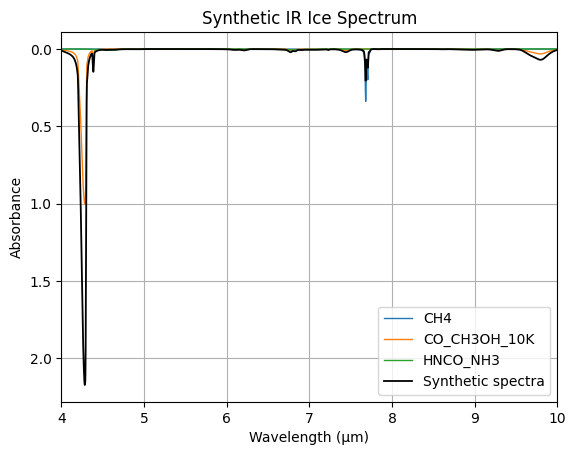

In [22]:
# Column densities of laboratory ices # Column densities in cm^-2
lab_column_densities = {"CH4":1.74e18,"CO_CH3OH_10K":1.2e18,"HNCO_NH3":2.4e18}
required_column_densities = {"CH4":1.05e18,"CO_CH3OH_10K":2.6e18,"HNCO_NH3":1.2e18}
keys_required = required_column_densities.keys()

R = 1 # Change factor for RAITR data
combined_wavelength=np.linspace(a, b, int((b-a)/r + 1))
combined_absorbance=np.zeros((int((b-a)/r + 1)))

#plt.figure(figsize=(22, 6))
for key in keys_required:
    coefficient = (required_column_densities[key]/lab_column_densities[key])/R
    wavelength,absorbance = spectrum_dict[key]
    combined_absorbance = combined_absorbance + (absorbance*coefficient)
    plt.plot(wavelength, absorbance,label=key,linewidth=1.0)

# To plot the synthetic spectra
plt.plot(combined_wavelength, combined_absorbance,label='Synthetic spectra',color='black',linewidth=1.3)
plt.xlim(a,b)
plt.xlabel('Wavelength (\u03BCm)')
plt.ylabel('Absorbance')
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.title('Synthetic IR Ice Spectrum')
plt.show()

### Adding continuum

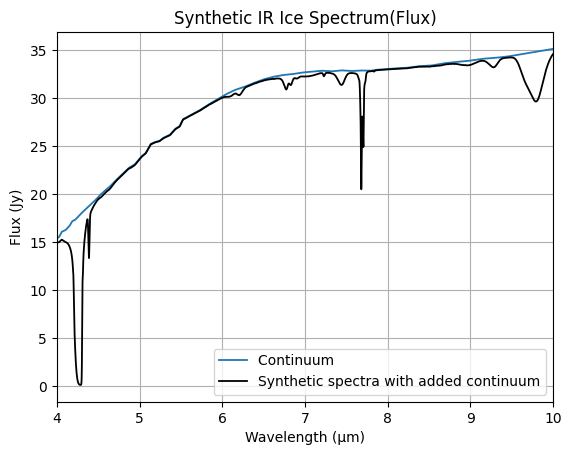

In [23]:
def read_data(file_path):
    # Read data from file
    data = np.loadtxt(file_path)
    # Separate x and y values
    x_values = data[:, 0]
    y_values = data[:, 1]
    spectra = (x_values , y_values)
    return spectra


continuum_name="C:\\Users\\manor\\OneDrive\\Desktop\\P452 Project\\continuum.txt" # Continuum spectra
fluxx = read_data(continuum_name)
fluxx = interpolator(fluxx, a, b, r) # Synethetic spectra
wavelength_flux, flux_continuum = fluxx

flux_synthetic=[]
for flux,absor in zip(flux_continuum, combined_absorbance):
    flux_syn=flux*math.exp(-2.3*absor)
    flux_synthetic.append(flux_syn)

#plt.figure(figsize=(22, 6))
plt.plot(wavelength_flux, flux_continuum, label='Continuum ',linewidth=1.3)
plt.plot(wavelength_flux, flux_synthetic, label='Synthetic spectra with added continuum',color='black',linewidth=1.3)
plt.xlim(a,b)
plt.xlabel('Wavelength (\u03BCm)')
plt.ylabel('Flux (Jy)')
plt.title('Synthetic IR Ice Spectrum(Flux)')
plt.legend()
plt.grid(True)
plt.show()